In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
module_path = os.path.abspath(
    os.path.join(
        "/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control"
    )
)
if module_path not in sys.path:
    sys.path.append(module_path)

from spillover_noise_q_env_config import (
    q_env_config as gate_q_env_config,
    circuit_context, phi, gamma
)
from quantumenvironment import QuantumEnvironmentV2
from context_aware_quantum_environment import ContextAwareQuantumEnvironmentV2
from hyperparameter_optimization import HyperparameterOptimizer
from gymnasium.wrappers import RescaleAction, ClipAction

from spillover_noise_quantum_environment import SpilloverNoiseQuantumEnvironment

from hpo_training_config import (
    HPOConfig,
    TotalUpdates,
    HardwareRuntime,
    TrainingConfig,
    TrainFunctionSettings
)

import logging
logging.basicConfig(
    level=logging.WARNING,
    format="%(asctime)s INFO %(message)s",  # hardcoded INFO level
    datefmt="%Y-%m-%d %H:%M:%S",
    stream=sys.stdout,
)

/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/venv_qiskit10/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2024-06-19 11:33:36,254 - qm - INFO     - Starting session: a206ac45-86f3-4d42-8d2c-62674ed96f83

 NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'unitary']
  Instructions with noise: ['custom_kron(rx,ident)_gate']
  Qubits with noise: [0, 1]
  Specific qubit errors: [('custom_kron(rx,ident)_gate', (0, 1))] 

Circuit context
                 ┌─────────────────────────────┐     
        q_0 -> 0 ┤0                            ├──■──
                 │  custom_kron(rx,ident)_gate │┌─┴─┐
        q_1 -> 1 ┤1                            ├┤ X ├
                 └─────────────────────────────┘└───┘
  ancilla_0 -> 2 ────────────────────────────────────
                                                     
  ancilla_1 -> 3 ────────────────────────────────────
                                                     
  ancilla_2 -> 4 ────────────────────────────────────
                                                     
  ancilla_3 -> 5 ────────────────────────────────────
                    

In [2]:
gate_q_env_config.backend_config.instruction_durations_dict

In [3]:
q_env = SpilloverNoiseQuantumEnvironment(
    gate_q_env_config, circuit_context, (phi, gamma)
)
q_env = ClipAction(q_env)
q_env = RescaleAction(q_env, -1.0, 1.0)

q_env.unwrapped.backend

AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>)

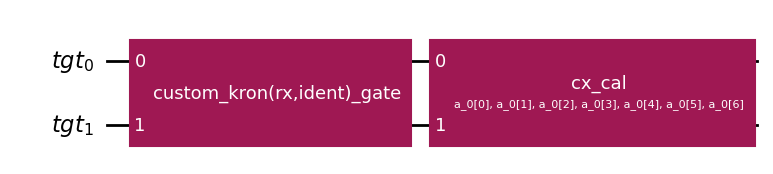

In [4]:
q_env.unwrapped.circuits[0].draw("mpl")

In [5]:
from helper_functions import load_from_yaml_file
from ppoV2 import CustomPPOV2

agent_config = load_from_yaml_file('/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/template_configurations/agent_config.yaml')

ppo_agent = CustomPPOV2(agent_config, q_env)

In [6]:
total_updates = TotalUpdates(10)
# hardware_runtime = HardwareRuntime(300)
training_config = TrainingConfig(training_constraint=total_updates, target_fidelities=[0.999, 0.9999], lookback_window=10, anneal_learning_rate=True, std_actions_eps=1e-2)

In [7]:
train_function_settings = TrainFunctionSettings(
    plot_real_time=True,
    print_debug=True,
    num_prints=1,
    hpo_mode=False,
    clear_history=True
)

In [8]:
q_env.unwrapped.phi_gamma_tuple

(0.7853981633974483, 0.01)

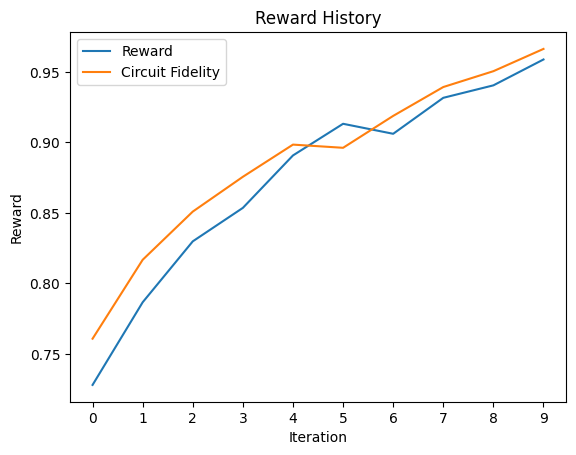

100%|██████████| 10/10 [02:03<00:00, 12.33s/it]

2024-06-19 11:35:41 INFO Target fidelity 0.999 not achieved within TotalUpdates(total_updates=10).
2024-06-19 11:35:41 INFO Target fidelity 0.9999 not achieved within TotalUpdates(total_updates=10).


{'env_ident_str': 'SpilloverNoise_phi-0.25pi_gamma-0.01_gate_calibration_cx-gate_physical_qubits_0-1',
 'reward_method': 'state',
 'training_constraint': TotalUpdates(total_updates=10),
 'avg_reward': [0.7279967992191927,
  0.7866407022497168,
  0.8298586980247824,
  0.8536014655374903,
  0.8907996865780154,
  0.9132507416140176,
  0.9061553287522234,
  0.9316721078673073,
  0.9405166976383126,
  0.9588698574442451],
 'std_action': [array([0.52828795, 0.52030736, 0.49688628, 0.44141015, 0.5007946 ,
         0.49578092, 0.4657523 ], dtype=float32),
  array([0.42268026, 0.4706812 , 0.46405083, 0.3908273 , 0.41168255,
         0.49967495, 0.3990557 ], dtype=float32),
  array([0.35317016, 0.42378375, 0.44370413, 0.38147938, 0.3263937 ,
         0.40705416, 0.37046233], dtype=float32),
  array([0.27763623, 0.39864016, 0.40157324, 0.3421868 , 0.2724629 ,
         0.36780965, 0.29549828], dtype=float32),
  array([0.23730698, 0.35157195, 0.3649202 , 0.34968355, 0.26039276,
         0.31430545,

In [9]:
ppo_agent.train(
    training_config=training_config,
    train_function_settings=train_function_settings
)